<class 'netCDF4.Group'>
group /FS/PRE:
    dimensions(sizes): phony_dim_5(684), phony_dim_6(49), phony_dim_7(2), phony_dim_8(176)
    variables(dimensions): float32 elevation(phony_dim_5, phony_dim_6), int32 landSurfaceType(phony_dim_5, phony_dim_6), float32 localZenithAngle(phony_dim_5, phony_dim_6, phony_dim_7), int32 flagPrecip(phony_dim_5, phony_dim_6), uint8 flagSigmaZeroSaturation(phony_dim_5, phony_dim_6, phony_dim_7), int16 binRealSurface(phony_dim_5, phony_dim_6, phony_dim_7), int16 binStormTop(phony_dim_5, phony_dim_6), float32 heightStormTop(phony_dim_5, phony_dim_6), float32 height(phony_dim_5, phony_dim_6, phony_dim_8), int16 binClutterFreeBottom(phony_dim_5, phony_dim_6), float32 sigmaZeroMeasured(phony_dim_5, phony_dim_6, phony_dim_7), float32 zFactorMeasured(phony_dim_5, phony_dim_6, phony_dim_8, phony_dim_7), float32 ellipsoidBinOffset(phony_dim_5, phony_dim_6), float32 snRatioAtRealSurface(phony_dim_5, phony_dim_6, phony_dim_7), float32 adjustFactor(phony_dim_5, phony

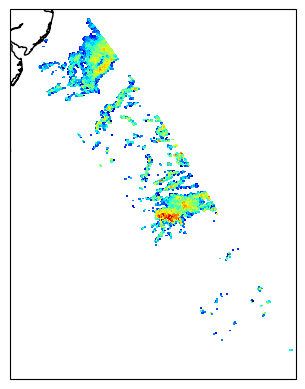

In [1]:
import io_subs
import numpy as np
fcmb='../GPM/ORO/VN/2B-CS-CONUS.GPM.DPRGMI.CORRA2022.20220510-S211231-E212029.046579.V07A.HDF5'
fdpr='../GPM/ORO/VN/2A-CS-CONUS.GPM.DPR.V9-20211125.20220510-S211231-E212029.046579.V07A.HDF5'
qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,oe_wvp,oe_lwp,oe_iwp,oesfc_precip,stormTop,nearSfcPrecip,zeroDegAltitude,surfaceType=io_subs.readCMB(fcmb)
import matplotlib.pyplot as plt
plt.figure()
import cartopy.crs as ccrs
ax=plt.subplot(111,projection=ccrs.PlateCarree())
import matplotlib.colors as mcolors
plt.pcolormesh(lon[300:600],lat[300:600],nearSfcPrecip[300:600],cmap="jet",norm=mcolors.LogNorm())
ax.coastlines()
import netCDF4 as nc
with nc.Dataset(fdpr) as fh:
    z_meas=fh["FS/PRE/zFactorMeasured"][:]
    storm_top=fh["FS/PRE/binStormTop"][:]
    bin_zero_deg=fh["FS/VER/binZeroDeg"][:]
    localZenithAngle=fh["FS/PRE/localZenithAngle"][:]
    print(fh["FS/PRE"])

print(localZenithAngle[0,:,0])
z_meas2=10*np.log10(0.5*(10**(0.1*z_meas[:,:,::2])+10**(0.1*z_meas[:,:,1::2])+1e-5))
pType=(pType/1e7).astype(int)
print(pType.max())
print(surfaceType[300:600])


In [2]:
import onnx_f90
print(dir(onnx_f90))
onnx_f90.init_onnx_f90()
#onnx_precip_rate,onnx_dm = onnx_retrieval_f90(z_ku_meas,z_ka_meas,p_type,bin_nodes,n_batch,n_seq,n_input,n_output,[n_scans])

['__doc__', '__f2py_numpy_version__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_onnx_f90_error', 'call_onnx_f90', 'init_onnx_f90', 'onnx_retrieval_f90']
 here


In [3]:
z_ku_meas=z_meas2[300:600,:,:,0].T
z_ka_meas=z_meas2[300:600,:,:,1].T
bin_nodes_slice=binNodes[300:600,:,:].T
print(bin_nodes_slice.shape)
print(z_ku_meas.shape)
p_type=pType[300:600,:].T
print(p_type.max())
a=np.nonzero(p_type>0)
print(len(a[0]))
n_seq=60
n_input=3
n_output=2
n_batch=len(a[0])

(5, 49, 300)
(88, 49, 300)
3
2855


In [ ]:
n_batch=1
nnx_precip_rate,onnx_dm = onnx_f90.onnx_retrieval_f90(z_ku_meas,z_ka_meas,p_type,bin_nodes_slice,n_batch,n_seq,n_input,n_output)